Тестовое задание
================

## SQL

В *SQLite* файле `issues.db` находится таблица `history`.

Таблица содержит следующие колонки:
* `issue_key` – уникальный ключ задачи
* `status` – статус задачи
* `minutes_in_status` – количество минут, которое задача находилась в статусе
* `previous_status` – предыдущий статус задачи
* `status_begin` – время перехода задачи в текущий статус
* `status_end` – время окончания нахождения задачи в текущем статусе

Время `status_begin` и `ended_at` указаны в формате unix epoch в *миллисекундах*.

Импортируем необходимые библиотеки.

In [172]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Создаем соединение с БД (файл с БД находится в папке с исполняемым .ipynb файлом).

In [173]:
con = sqlite3.connect('issues.db')

Тестовый запрос (проверка соединения и генерации датафрейма).

In [174]:
query_test = '''
SELECT *
FROM history
LIMIT 10
'''
test_df = pd.read_sql_query(query_test, con)
test_df

,issue_key,status,minutes_in_status,previous_status,status_begin,status_end
0,C-40460,Open,113.0,None,1669363867000,1.669371e+12
1,C-40460,In Progress,6289.0,Open,1669370640119,1.669748e+12
2,C-40460,In Review,2484.0,In Progress,1669747964986,1.669897e+12
3,B-7067,Closed,NaN,Test,1668583633246,NaN
4,B-6168,In Progress,187.0,Open,1655891591619,1.655903e+12
5,B-4801,In Progress,1.0,Open,1650636048496,1.650636e+12
6,B-3222,Closed,NaN,Resolved,1644833437722,NaN
7,B-59,Resolved,71.0,Open,1610616208000,1.610620e+12
8,C-40460,In Owl,8407.0,In Review,1669897022965,1.670401e+12
9,C-40460,Open,0.0,In Owl,1670401438890,1.670401e+12


### Задача 1

Напишите SQL запрос, который для всех задач, открытых на момент времени `T`, выведет:
* ключ задачи
* время создания задачи
* статус на момент `T`

Задача считается открытой на момент времени `T`, если к этому времени последний статус задачи был любой кроме `Closed` и `Resolved`.

Оформите запрос таким образом, чтобы, изменив дату, его можно было использовать для поиска открытых задач в любой момент времени как в прошлом, так и в настоящем.

Здесь и далее все даты и времена должны быть переведены в удобочитаемый вид.

Создадим функцию generating_df_query для создания датафрейма по запросу.

In [175]:
def generating_df_query(searching_date):
        '''
        Функция для генерирования датафрейма из базы данных issues.db (таблица history).
        Функция принимает на вход момент времени T, до которого будет сформирован
        датасет с полями:        
                issue_key – уникальный ключ задачи;
                start_of_task – время создания задачи;
                status – последний статус задачи на момент времени T (кроме статусов 'Closed' и 'Resolved').
        '''
        con = sqlite3.connect('issues.db')
        query = f'''
                WITH cte AS
                        (SELECT  issue_key, 
                                MAX(status_begin) AS status_begin,
                                MIN(status_begin) AS start_of_task
                        FROM
                                (SELECT  issue_key, 
                                        datetime(status_begin/1000, 'unixepoch') AS status_begin,
                                        status
                                FROM history
                                WHERE status_begin <= strftime('%s', '{searching_date}') * 1000
                                        AND status NOT IN ('Closed', 'Resolved'))                  
                        GROUP BY
                        issue_key)
                
                SELECT  cte.issue_key,
                        cte.start_of_task,
                        t2.status
                FROM cte JOIN (SELECT   status,  
                                        datetime(status_begin/1000, 'unixepoch') AS status_begin
                                FROM history) t2
                                ON 
                                cte.status_begin = t2.status_begin
                ORDER BY 
                        cte.issue_key
                '''
        dataframe = pd.read_sql_query(query, con)
        return dataframe

Проверим работу функции. Возьмем для теста задачу C-40460. Выведем все ее статусы и их время.

In [176]:
test_q = '''
SELECT  
    issue_key,
    status,
    datetime(status_begin/1000, 'unixepoch') AS status_begin
FROM 
    history
WHERE 
    issue_key = 'C-40460'
LIMIT 
    1000
'''
t_df = pd.read_sql_query(test_q, con)
t_df

,issue_key,status,status_begin
0,C-40460,Open,2022-11-25 08:11:07
1,C-40460,In Progress,2022-11-25 10:04:00
2,C-40460,In Review,2022-11-29 18:52:44
3,C-40460,In Owl,2022-12-01 12:17:02
4,C-40460,Open,2022-12-07 08:23:58
5,C-40460,In Progress,2022-12-07 08:24:09
6,C-40460,In Testing,2022-12-07 08:25:13
7,C-40460,In Progress,2022-12-07 08:25:28
8,C-40460,In Testing,2022-12-07 08:25:32


Время создания задачи - "2022-11-25 08:11:07", последний статус - "In Testing". Проверим работу функции, указав время T = "2022-12-08".

In [177]:
data = generating_df_query('2022-12-08')

Проверим какие значения содержит сформированный датафрейм для задачи C-40460.

In [178]:
data.query('issue_key == "C-40460"')

,issue_key,start_of_task,status
1295,C-40460,2022-11-25 08:11:07,In Testing


Функция работает корректно.

## Pandas

Файл `task_history.csv` содержит исторические данные системы сборки (e.g. *jenkins*, *teamcity*, etc.)

Каждая запись в истории описывает отдельный запуск задачи `build_name` на рабочей машине `worker`.<br/>
Для любого запуска известны автор `author` и проект `project`, в рамках которого был запущен расчет данной задачи.

===================================\
Подгрузим датасет, осмотрим тип столбцов.

In [179]:
df = pd.read_csv('task_history.csv')
df.head()

,task_id,start_time,finish_time,status,worker,build_name,author,project
0,44973,2005-06-26 09:05:45.716,2005-06-26 09:05:45.997,success,worker_00,test_cyan_texture,Kenny Smith,Halo Anniversary
1,44974,2005-06-26 09:05:46.200,2005-06-26 09:05:46.497,success,worker_01,test_cyan_texture,Kenny Smith,Halo Anniversary
2,44975,2005-06-26 09:05:47.357,2005-06-26 09:06:01.213,success,worker_02,test_cyan_texture,Kenny Smith,Halo Anniversary
3,44977,2005-06-26 09:06:19.273,2005-06-26 09:10:44.734,success,worker_02,test_cyan_texture,Kenny Smith,Halo Anniversary
4,44979,2005-06-26 09:12:00.883,2005-06-26 09:14:29.941,success,worker_04,test_cyan_texture,Kenny Smith,Halo Anniversary


In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160492 entries, 0 to 160491
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   task_id      160492 non-null  int64 
 1   start_time   160492 non-null  object
 2   finish_time  160492 non-null  object
 3   status       160492 non-null  object
 4   worker       160492 non-null  object
 5   build_name   160492 non-null  object
 6   author       160492 non-null  object
 7   project      160492 non-null  object
dtypes: int64(1), object(7)
memory usage: 9.8+ MB


Приведем столбцы start_time и finish_time к формату datetime.

In [181]:
df[['start_time', 'finish_time']] = df[['start_time', 'finish_time']].apply(pd.to_datetime)
df.dtypes

task_id                 int64
start_time     datetime64[ns]
finish_time    datetime64[ns]
status                 object
worker                 object
build_name             object
author                 object
project                object
dtype: object

### Задача 2

Для каждой недели распечатайте топ-3 пользователей, потребивших наибольшее количество машиночасов.

Выведите для данных пользователей процент потребленных ресурсов от общего объема расчетов за эту неделю.

Получим номера недель.

In [182]:
df['week_num'] = df['start_time'].dt.isocalendar().week

Создадим столбец 'time_spent' с затраченным временем.

In [183]:
df['time_spent'] = df['finish_time'] - df['start_time']

In [184]:
df.head()

,task_id,start_time,finish_time,status,worker,build_name,author,project,week_num,time_spent
0,44973,2005-06-26 09:05:45.716,2005-06-26 09:05:45.997,success,worker_00,test_cyan_texture,Kenny Smith,Halo Anniversary,25,0 days 00:00:00.281000
1,44974,2005-06-26 09:05:46.200,2005-06-26 09:05:46.497,success,worker_01,test_cyan_texture,Kenny Smith,Halo Anniversary,25,0 days 00:00:00.297000
2,44975,2005-06-26 09:05:47.357,2005-06-26 09:06:01.213,success,worker_02,test_cyan_texture,Kenny Smith,Halo Anniversary,25,0 days 00:00:13.856000
3,44977,2005-06-26 09:06:19.273,2005-06-26 09:10:44.734,success,worker_02,test_cyan_texture,Kenny Smith,Halo Anniversary,25,0 days 00:04:25.461000
4,44979,2005-06-26 09:12:00.883,2005-06-26 09:14:29.941,success,worker_04,test_cyan_texture,Kenny Smith,Halo Anniversary,25,0 days 00:02:29.058000


Создадим промежуточную таблицу, сгруппировав по столбцу с номером недели и юзеру, и выведем сумму затраченного времени для каждого юзера и каждой группы. 

In [185]:
top_of_week = df.groupby(by=['week_num', 'worker'], as_index=False).agg({'time_spent':'sum'})\
    .sort_values(by=['week_num','time_spent'], ascending=[True, False])
top_of_week

,week_num,worker,time_spent
79,25,worker_51,5 days 16:24:59.864000
27,25,worker_1d,5 days 16:16:38.058000
68,25,worker_46,5 days 15:12:28.708000
37,25,worker_27,5 days 13:29:10.149000
11,25,worker_0d,5 days 12:42:20.301000
...,...,...,...
395,28,worker_2b,0 days 01:14:56.558000
444,28,worker_5c,0 days 01:14:24.182000
355,28,worker_01,0 days 01:08:07.811000
462,28,worker_6e,0 days 00:40:52.684000


Проведем еще одну группировку (по номеру недели) и выведем первые 3 строки из каждой группы (заранее отсортированные по убыванию затраченного времени).

In [186]:
top_of_week.groupby(by='week_num').head(3)

,week_num,worker,time_spent
79,25,worker_51,5 days 16:24:59.864000
27,25,worker_1d,5 days 16:16:38.058000
68,25,worker_46,5 days 15:12:28.708000
106,26,worker_04,6 days 08:59:37.467000
157,26,worker_37,6 days 07:57:59.532000
131,26,worker_1d,6 days 07:43:15.212000
322,27,worker_6c,5 days 03:43:29.408000
295,27,worker_51,5 days 01:31:01.382000
228,27,worker_0d,5 days 00:48:48.464000
366,28,worker_0d,4 days 15:32:27.918000


### Задача 3

Отобразите график с ежедневным потреблением машинного времени каждым проектом.

Для визуализации можно использовать следующие библиотеки: `matplotlib`, `seaborn` или `altair`.

In [187]:
df['date'] = df['finish_time'].dt.date

Преобразуем столбец 'time_spent' в количество затраченных секунд.

In [188]:
df['time_spent'] = df['time_spent'].dt.total_seconds()

In [189]:
df['time_spent'] = df['time_spent'] / 3600

In [190]:
machine_time = df.groupby(by=['project', 'date'], as_index=False).agg({'time_spent':'sum'})
machine_time

,project,date,time_spent
0,Halo Anniversary,2005-06-20,27.240106
1,Halo Anniversary,2005-06-21,28.989350
2,Halo Anniversary,2005-06-22,22.093017
3,Halo Anniversary,2005-06-23,17.385260
4,Halo Anniversary,2005-06-24,8.552613
...,...,...,...
140,World War Z,2005-07-14,217.035889
141,World War Z,2005-07-15,137.772392
142,World War Z,2005-07-16,118.432318
143,World War Z,2005-07-17,213.105891


Выведем график. (Перебрав несколь вариантов графиков, оптимальным показался групповой barplot).

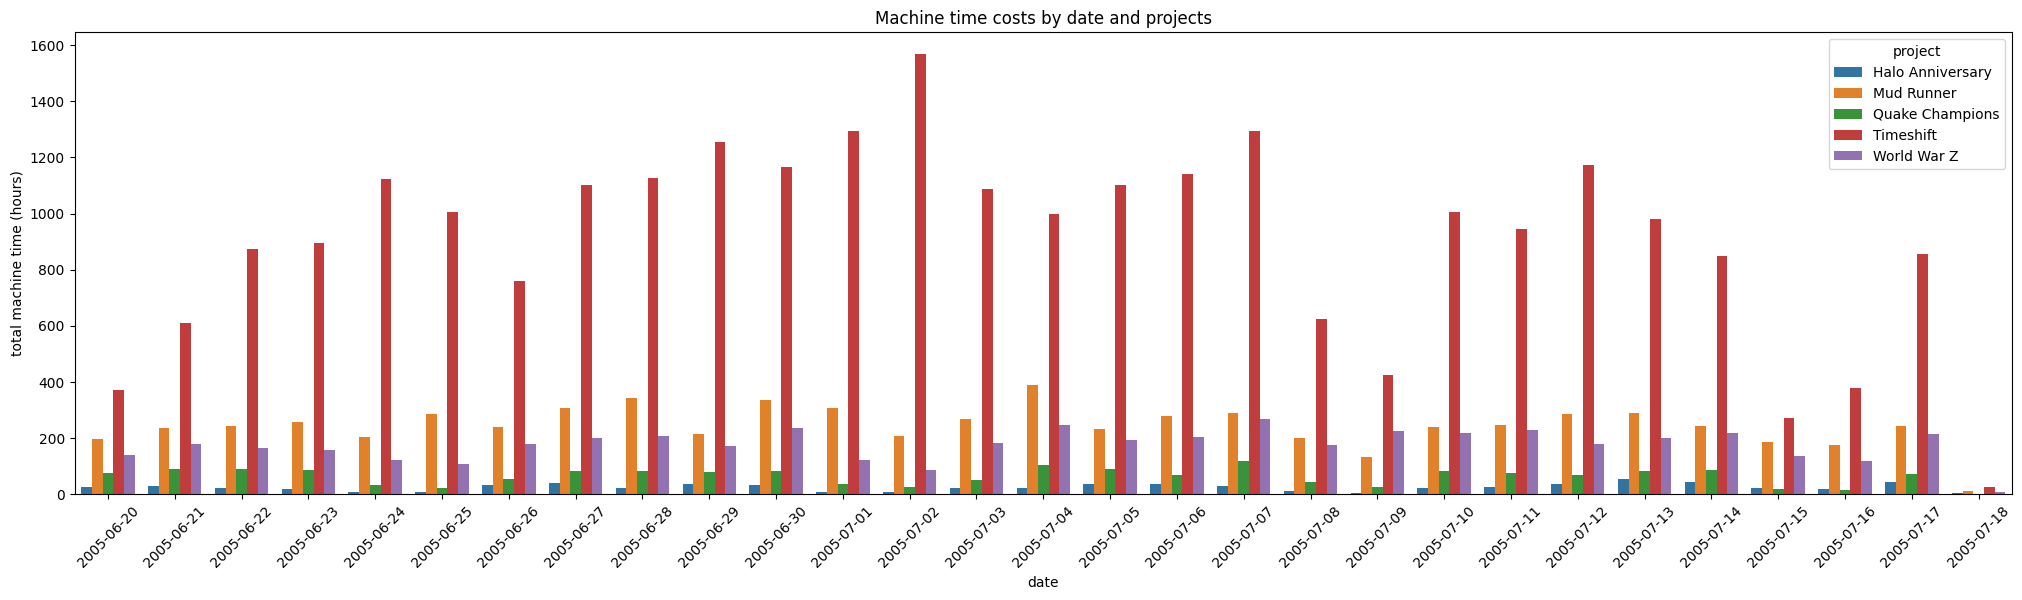

In [207]:
plt.figure(figsize=(25, 6))
plot = sns.barplot(data=machine_time, 
                   x='date', 
                   y='time_spent', 
                   hue='project', 
                   errorbar=None)
plot.set(title='Machine time costs by date and projects')
plot.set(xlabel='date', ylabel='total machine time (hours)')
plot.tick_params(axis='x', rotation=45)

### Задача 4

Рассмотрим *еженедельное* общее потребление ресурсов. На второй неделе можно заметить всплеск нагрузки с ее последующим планомерным снижением.

Проанализируйте предоставленные данные и найдите, с чем связано подобное поведение.

In [208]:
week_load = df.groupby(by='week_num', as_index=False).agg({'time_spent':'sum'})
week_load

,week_num,time_spent
0,25,9074.092504
1,26,12412.453679
2,27,10498.085683
3,28,9073.227367


[Text(0.5, 0, 'week number'), Text(0, 0.5, 'total machine time (hours)')]

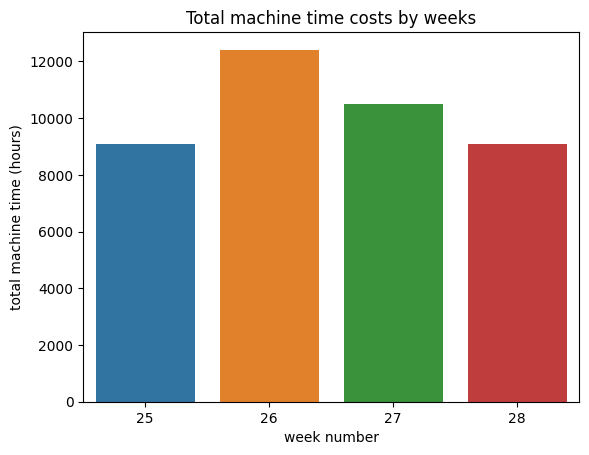

In [211]:
wl = sns.barplot(data=week_load, 
                   x='week_num', 
                   y='time_spent',
                   errorbar=None)
wl.set(title='Total machine time costs by weeks')
wl.set(xlabel='week number', ylabel='total machine time (hours)')